## Training Notebook

Define and train an RNN in Tensorflow. This model evaluates spamminess by message, i.e. each message is considered independent of all others.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import hashlib
import unicodedata
import re
import string
import itertools

from tensorflow import set_random_seed

# Set random seeds for reproducible results
np.random.seed(42)
set_random_seed(42)

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

# Rough proportion of data in training set
train_split = 0.7
# Max character length of a message, hardcoded in OSRS as 80 chars
max_chars = 80
# Threshold above which a message is classed as spam
spam_thresh = 0.50

# Get rid of pandas warning
pd.options.mode.chained_assignment = None

tf.__version__

'1.13.0-rc2'

## Load and pre-process data

In [2]:
# Load and deduplicate the dataset

df = pd.read_csv("dataset.csv", index_col=0)
df = df.drop_duplicates('message').reset_index(drop=True)

In [59]:
# Split the dataset using MD5 hash to make splitting deterministic and repeatable after adding new data
# The split proportion won't be exactly as specified, but it'll be good enough

split_val = (2 ** 32 - 1) * train_split
#df['usermd5'] = [int(hashlib.md5(user.encode("utf-8")).hexdigest()[0:8], 16) for user in df['user']]
df['usermd5'] = [int(hashlib.md5((row[1]['user'] + row[1]['message']).encode("utf-8")).hexdigest()[0:8], 16) 
                 for row in df.iterrows()]
traindf = df[df['usermd5'] < split_val]
testdf = df[df['usermd5'] > split_val]
df.drop(columns=['usermd5'], inplace=True)
traindf.drop(columns=['usermd5'], inplace=True)
testdf.drop(columns=['usermd5'], inplace=True)

# Clean message function. Remove punctuation, repeated whitespace, and convert everything to lowercase
# We don't tokenize by words, instead just use ascii encoding
def clean_message(msg):
    #msg = msg.translate(str.maketrans('', '', string.punctuation))
    #msg = msg.lower()
    #msg = re.sub(' +', ' ', msg)
    return unicodedata.normalize('NFKD', msg).encode('ascii','ignore')
    
encoded_msgs = [list(clean_message(msg)) for msg in np.array(df['message'])]
seqs = pad_sequences(encoded_msgs, maxlen=max_chars)
seqs = seqs.reshape((len(seqs), max_chars, 1))

msg_train = traindf['message']
msg_test = testdf['message']

X_train = seqs[traindf.index]
X_test = seqs[testdf.index]

Y_train = np.array(traindf['spam'])
Y_test = np.array(testdf['spam'])

print("Proportion of data in train set: {}".format(len(X_train) / (len(X_train) + len(X_test))))
print("Proportion of data in test set: {}".format(len(X_test) / (len(X_train) + len(X_test))))

Proportion of data in train set: 0.6954476479514415
Proportion of data in test set: 0.3045523520485584


## Set up and train model

In [100]:
# Define Keras model constructor
# Model archetecture:
# Input layer of length 80
# Hidden LSTM layer
# Hidden dense layer
# Output layer, FC with sigmoid activation

def create_model(l1=32, d1=16):
    inputs = Input(shape=(80,1))
    X = Bidirectional(LSTM(l1))(inputs)
    X = Dense(d1, activation='tanh')(X)
    output = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(name='precision'), Recall(name='recall')])
    return model

In [134]:
# Train the model, checking performance on validation set. 
# Model tends to converge before around 20 epochs with batch size of 128.
# Training takes about 2 minutes on an i3. GPU acceleration doesn't really help this model.

K.clear_session()

model = create_model(l1=48, d1=32)

history = model.fit(
    X_train, 
    Y_train, 
    epochs=30,
    validation_data=(X_test, Y_test), 
    batch_size=64, 
    verbose=2)

K.set_learning_phase(0)

Train on 4583 samples, validate on 2007 samples
Epoch 1/30
 - 9s - loss: 0.1699 - acc: 0.9455 - precision: 0.6939 - recall: 0.4172 - val_loss: 0.0799 - val_acc: 0.9801 - val_precision: 0.8562 - val_recall: 0.8792
Epoch 2/30
 - 8s - loss: 0.0739 - acc: 0.9791 - precision: 0.8402 - recall: 0.8712 - val_loss: 0.0614 - val_acc: 0.9816 - val_precision: 0.8733 - val_recall: 0.8792
Epoch 3/30
 - 7s - loss: 0.0656 - acc: 0.9828 - precision: 0.8921 - recall: 0.8620 - val_loss: 0.0565 - val_acc: 0.9870 - val_precision: 0.9556 - val_recall: 0.8658
Epoch 4/30
 - 7s - loss: 0.0586 - acc: 0.9841 - precision: 0.8941 - recall: 0.8804 - val_loss: 0.0552 - val_acc: 0.9860 - val_precision: 0.9291 - val_recall: 0.8792
Epoch 5/30
 - 7s - loss: 0.0537 - acc: 0.9854 - precision: 0.9164 - recall: 0.8742 - val_loss: 0.0522 - val_acc: 0.9856 - val_precision: 0.9545 - val_recall: 0.8456
Epoch 6/30
 - 7s - loss: 0.0514 - acc: 0.9847 - precision: 0.9051 - recall: 0.8773 - val_loss: 0.0444 - val_acc: 0.9846 - val_p

## Evaluate Model

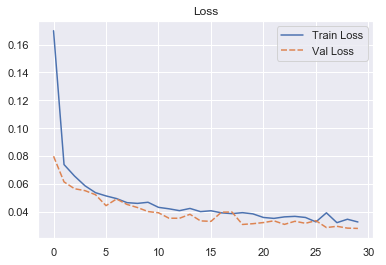

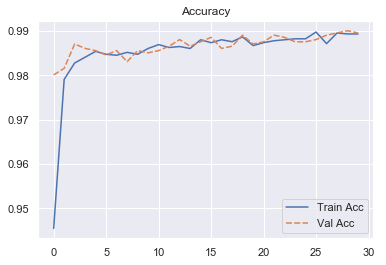

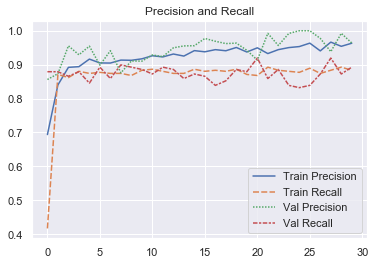

In [135]:
sns.lineplot(
    data=pd.DataFrame({'Train Loss': history.history['loss'], 'Val Loss': history.history['val_loss']})
).set_title('Loss')
plt.show()

sns.lineplot(
    data=pd.DataFrame({'Train Acc': history.history['acc'], 'Val Acc': history.history['val_acc']})
).set_title('Accuracy')
plt.show()

sns.lineplot(
    data=pd.DataFrame({
        'Train Precision': history.history['precision'], 
        'Train Recall': history.history['recall'],
        'Val Precision': history.history['val_precision'], 
        'Val Recall': history.history['val_recall'],
    })
).set_title('Precision and Recall')
plt.show()

In [136]:
# Make predictions on entire dataset and re-split into test and train sets

allpreds = model.predict(seqs)

df['pred'] = allpreds
df['predclass'] = allpreds > spam_thresh
testdf = df.iloc[testdf.index]
traindf = df.iloc[traindf.index]

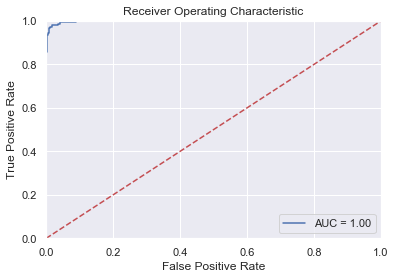

In [137]:
fpr, tpr, threshold = roc_curve(Y_test, testdf['pred'])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1.0, 'Test set confusion matrix')

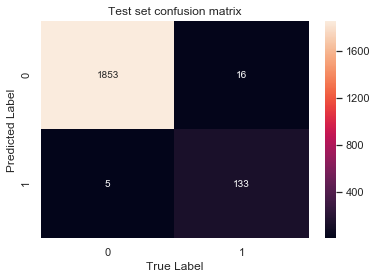

In [138]:
# Test set confusion matrix and misclassified examples

conf = confusion_matrix(testdf['predclass'], testdf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='d')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Test set confusion matrix")

Text(0.5, 1.0, 'Train set confusion matrix')

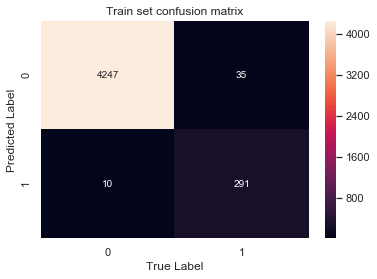

In [139]:
# Training set confusion matrix and misclassified examples

conf = confusion_matrix(traindf['predclass'], traindf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='g')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Train set confusion matrix")

In [140]:
# Show misclassified test and train samples

display(testdf[testdf['spam'] != testdf['predclass']])
display(traindf[traindf['spam'] != traindf['predclass']])

,user,message,spam,pred,predclass
119,Ix2YourStack,Doubling Cash~!~!,True,0.020044,False
191,TheSlaybodyz,Giving away 3M on Twitch! @Slaybodyz - Get he...,False,0.508523,True
419,Bettygodzj,"""Grandrolling"" Cc | Dice Game & Trusted Ranks ...",True,0.423020,False
912,Hingle26,Join [-Chatswap-] Cc For Daily Drop Parties/Gi...,True,0.106248,False
2902,RNG223,Legit doubling!_!_!__!,True,0.094805,False
2906,RNG223,Legit doubling!+_!!__!_!_!,True,0.285842,False
2908,RNG223,Legit doubling_!_!_!_!_!,True,0.186828,False
2950,RNG223,Legit doubling!-!_!_!_!_!,True,0.281851,False
4513,Symphorien,Soo you charge it 1k to ? Save 1k ?,False,0.586249,True
4664,iTANK 0o,Search Munk23 on Faceb00k to participate in a ...,True,0.477509,False


,user,message,spam,pred,predclass
22,cgva,/-/R u n e c h a t/*/* b e s t ---and legit -*...,True,0.265637,False
151,TheSlaybodyz,5Giving away 3M on Twitch! @Slaybodyz - Get h...,False,0.554268,True
195,Ix2YourStack,50K Taken~!~!,True,0.057054,False
201,Ix2YourStack,100K Given~!~!,True,0.082581,False
345,RNG 2403,Blunt Joints has been paid: 600K!,True,0.450026,False
373,<img=10>IT InfoSec,"Ha. If only, jdtm, then I would be selling stu...",False,0.676806,True
631,StupidBrain,"He has 2,147 million worth of platnium token @...",False,0.795511,True
906,Hingle26,Join [Chatswap] Cc to Swap Your 07/Rs3 Gold!,True,0.322684,False
909,Hingle26,Join | Chatswap | Cc To Chat And Swap Your Gp!,True,0.388461,False
1126,qdad,0m each Search on youtube Eum582 To Win9237,True,0.391630,False


In [141]:
# Test cumulative spamminess of a user

users = {}
spampred = []

for idx, row in testdf.iterrows():
    prior, num = users.get(row['user'], (1 - spam_thresh, 1))
    spampred.append(row['pred'] > 1 - prior)
    users[row['user']] = ((prior * num + row['pred']) / (num + 1), num + 1)
    
testdf['cumulativespam'] = spampred

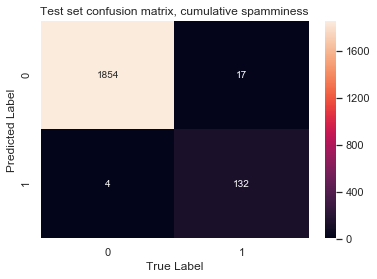

,user,message,spam,pred,predclass,cumulativespam
119,Ix2YourStack,Doubling Cash~!~!,True,0.020044,False,False
419,Bettygodzj,"""Grandrolling"" Cc | Dice Game & Trusted Ranks ...",True,0.423020,False,False
912,Hingle26,Join [-Chatswap-] Cc For Daily Drop Parties/Gi...,True,0.106248,False,False
913,Hingle26,==Chatswap== Cc 250m+ Giveaways Per Week!,True,0.524540,True,False
2902,RNG223,Legit doubling!_!_!__!,True,0.094805,False,False
2906,RNG223,Legit doubling!+_!!__!_!_!,True,0.285842,False,False
2908,RNG223,Legit doubling_!_!_!_!_!,True,0.186828,False,False
2950,RNG223,Legit doubling!-!_!_!_!_!,True,0.281851,False,False
4513,Symphorien,Soo you charge it 1k to ? Save 1k ?,False,0.586249,True,True
4707,X2 Cat,[Lose] Rolled [50] Unlucky :(,True,0.281185,False,False


In [142]:
conf = confusion_matrix(testdf['cumulativespam'], testdf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='g')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Test set confusion matrix, cumulative spamminess")
plt.show()

testdf[testdf['spam'] != testdf['cumulativespam']]

In [143]:
# Save as before, only on the training set

users = {}
spampred = []

for idx, row in traindf.iterrows():
    prior, num = users.get(row['user'], (1 - spam_thresh, 1))
    spampred.append(row['pred'] > 1 - prior)
    users[row['user']] = ((prior * num + row['pred']) / (num + 1), num + 1)
    
traindf['cumulativespam'] = spampred

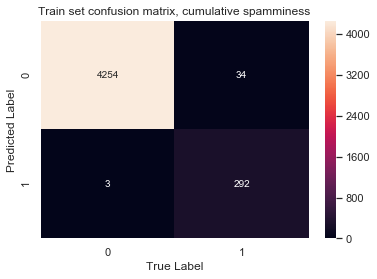

,user,message,spam,pred,predclass,cumulativespam
22,cgva,/-/R u n e c h a t/*/* b e s t ---and legit -*...,True,0.265637,False,False
195,Ix2YourStack,50K Taken~!~!,True,0.057054,False,False
201,Ix2YourStack,100K Given~!~!,True,0.082581,False,False
345,RNG 2403,Blunt Joints has been paid: 600K!,True,0.450026,False,False
906,Hingle26,Join [Chatswap] Cc to Swap Your 07/Rs3 Gold!,True,0.322684,False,False
909,Hingle26,Join | Chatswap | Cc To Chat And Swap Your Gp!,True,0.388461,False,False
1126,qdad,0m each Search on youtube Eum582 To Win9237,True,0.391630,False,False
1206,Pikud,Trading up 1 oak log [30gp] ( streaming road t...,False,0.661473,True,True
1215,skillerbrbke,Quiiting rs giving 10 precent what you show in...,True,0.003781,False,False
2375,UnBonCafe,"Watch out, Imposters Says Original!! (100k to ...",True,0.366807,False,False


In [144]:
conf = confusion_matrix(traindf['cumulativespam'], traindf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='g')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Train set confusion matrix, cumulative spamminess")
plt.show()

traindf[traindf['spam'] != traindf['cumulativespam']]

## Save and export model

In [145]:
# Save the model
model.save("antispam.h5")
model.save_weights('antispam_weights.h5')

In [146]:
# Saves model as .txt files for loading in Java

def save_weights_txt(layer):
    config = layer.get_config()
    allweights = layer.get_weights()
    name = config["name"]
    for i, weights in enumerate(allweights):
            np.savetxt("model_weights/{}_params_{}.txt".format(name, i), weights)

for layer in model.layers:
    config = layer.get_config()
    allweights = layer.get_weights()
    name = config["name"]
    if "bidirectional" in name:
        save_weights_txt(layer.forward_layer)
        save_weights_txt(layer.backward_layer)
    else:
        save_weights_txt(layer)

In [52]:
# Saves model as .npy files for loading in Java

def save_weights_npy(layer):
    config = layer.get_config()
    allweights = layer.get_weights()
    name = config["name"]
    for i, weights in enumerate(allweights):
            np.save("model_weights/{}_params_{}.npy".format(name, i), weights)

for layer in model.layers:
    config = layer.get_config()
    allweights = layer.get_weights()
    name = config["name"]
    if "bidirectional" in name:
        save_weights_npy(layer.forward_layer)
        save_weights_npy(layer.backward_layer)
    else:
        save_weights_npy(layer)

In [134]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[3].output)

aencoded_msgs = np.array([list(clean_message(msg)) for msg in ["Blunt Joints has been paid: 600K!"]])
aencoded_msgs = aencoded_msgs.reshape(1,33,1)
intermediate_output = intermediate_layer_model.predict(aencoded_msgs)
intermediate_output

array([[0.05986069]], dtype=float32)

In [166]:
np.rot90(encoded_msgs[0])

ValueError: Axes must be different.